In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm

In [2]:
import pyathena as pa
coolftn=pa.coolftn('../pyathena/coolftn.p')

In [3]:
import pyathena.synthetic_observations as syn

In [4]:
import healpy as hp

In [5]:
base='/tigress/changgoo/'
id='MHD_2pc_S'

In [6]:
import glob
fnames=glob.glob('%s%s/id0/%s.????.vtk' % (base,id,id))
rstfnames=glob.glob('%s%s/id0/%s.????.rst' % (base,id,id))+glob.glob('%s%s/rst/%s.????.rst' % (base,id,id))
fnames.sort()
i=0
ds=None

In [7]:
par,blocks,fields=pa.parse_par(rstfnames[0])

In [8]:
fnames[363-350-1]

'/tigress/changgoo/MHD_2pc_S/id0/MHD_2pc_S.0363.vtk'

In [9]:
%%time
ds=pa.AthenaDataSet(fnames[363-350-1],ds=None)
print ds.domain['time']
#i=i+100

362.0
CPU times: user 846 ms, sys: 5.11 s, total: 5.96 s
Wall time: 2min 13s


In [10]:
mhd=True
domain=ds.domain
domain['qshear']=eval(par['problem']['qshear'][0])
domain['Omega']=eval(par['problem']['Omega'][0])

In [11]:
center=[[0.,0.,0.],[256.,256.,0.],[-256.,256.,0.],[-256.,-256.,0.],[256.,-256.,0.]]
for c in center:
    print c

[0.0, 0.0, 0.0]
[256.0, 256.0, 0.0]
[-256.0, 256.0, 0.0]
[-256.0, -256.0, 0.0]
[256.0, -256.0, 0.0]


In [12]:
print ds.dir, ds.id, ds.step

/tigress/changgoo/MHD_2pc_S/ MHD_2pc_S 0363


In [13]:
import os

In [14]:
Nside=512
npix=hp.nside2npix(Nside)
losdir='%s/los/%s.%d.%d/' % (ds.dir,ds.step,Nside,0)
losfiles=glob.glob(losdir+'*.los.p')

In [41]:
los_old=pd.read_pickle(losfiles[0])
los={}
los['density']=np.array(los_old['density'])
los['sarr']=np.array(los_old.index)
for axis in ['X','Y','Z']:
    los['velocity_%s' % axis]=np.array(los_old['velocity_%s' % axis])
    los['magnetic_field_%s' % axis]=np.array(los_old['magnetic_field_%s' % axis])

In [45]:
reload(syn)
syn.los_to_dustpol(los)

(<Quantity 0.04749165642903061 MJy / sr>,
 <Quantity 0.0015376998904030657 MJy / sr>,
 <Quantity -0.000390509805416451 MJy / sr>)

In [48]:
Imap=np.zeros(npix)+hp.UNSEEN
for ipix in xrange(0,npix,Nside):
    losfile=losdir+'%s.%d.los.p' % (ds.id,ipix)
    I,Q,U=syn.los_to_dustpol(los)
    Imap[ipix]=I.value

In [63]:
0.05*npix/3600.

43.69066666666667

In [61]:
%%time
for i in range(npix):
    pass

CPU times: user 231 ms, sys: 31 ms, total: 262 ms
Wall time: 275 ms


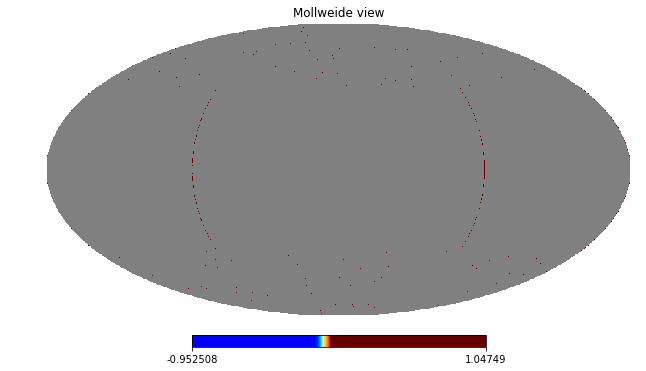

In [49]:
cmap=syn.load_planck_cmap()
hp.mollview(Imap,norm='hist',cmap=cmap)

In [49]:
f='/tigress/changgoo/MHD_2pc_S/dustpol/MHD_2pc_S.0363.n4.c0.fits'
maps=hp.read_map(f,field=(0,1,2))
hp.mollview(np.log10(maps[0]),cmap=cmap,min=-2,max=1,
            unit=r'log$_{10}(I_{353})$ [MJy/sr]')
hp.graticule(dpar=45)

IOError: [Errno 2] No such file or directory: '/tigress/changgoo/MHD_2pc_S/dustpol/MHD_2pc_S.0363.n4.c0.fits'

/tigress/changgoo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.0 180.0 -180.0 180.0
The interval between parallels is 45 deg 0.00'.
The interval between meridians is 45 deg 0.00'.


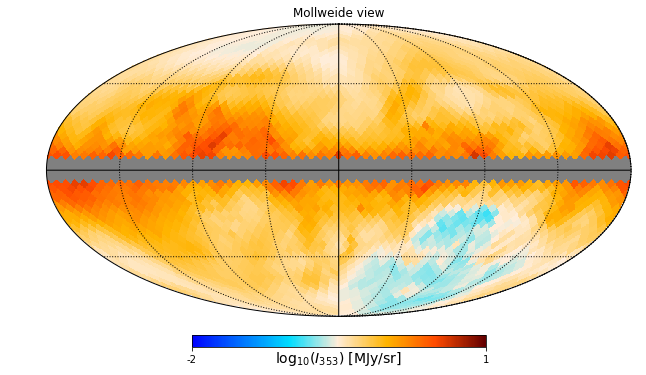

In [27]:
hp.mollview(np.log10(Imap),cmap=cmap,min=-2,max=1,
            unit=r'log$_{10}(I_{353})$ [MJy/sr]')
hp.graticule(dpar=45)

In [323]:
idx=Imap == hp.UNSEEN

In [324]:
1-idx.sum()/float(hp.nside2npix(Nside))

0.89583333333333337

In [277]:
%%time
Nside=128
ipix=50000
deltas=domain['dx'][2]/16.
los=syn.get_los(data,domain,Nside,ipix,deltas=deltas)
print np.rad2deg(hp.pix2ang(Nside,ipix))

[ 60.68680104  56.6015625 ]
CPU times: user 27 ms, sys: 0 ns, total: 27 ms
Wall time: 26.4 ms


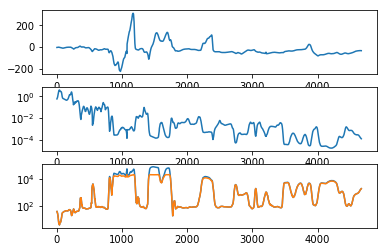

In [282]:
plt.subplot(311)
plt.plot(los['sarr'],los['velocity_Z'],'-')
plt.subplot(312)
plt.semilogy(los['sarr'],los['density'],'-')
plt.subplot(313)
plt.semilogy(los['sarr'],los['temperature'],'-')
plt.semilogy(los['sarr'],syn.Tspin_WF(los['temperature']*u.K,los['density']/u.cm**3,nalpha=1.e-5),'-')

In [325]:
%%time
line=syn.los_to_HI(los,vmax=150,dvch=1)

CPU times: user 1.06 s, sys: 53 ms, total: 1.11 s
Wall time: 1.11 s


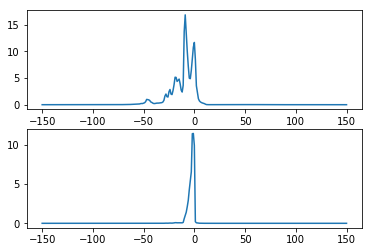

In [284]:
plt.subplot(211)
plt.plot(line['vchannel'],line['TB'])
plt.subplot(212)
plt.plot(line['vchannel'],line['tau'])

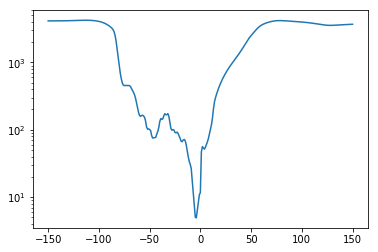

In [285]:
plt.semilogy(line['vchannel'],line['TB']/(1-np.exp(-line['tau'])))

In [212]:
reload(syn)

<module 'pyathena.synthetic_observations' from '../pyathena/synthetic_observations.pyc'>

In [326]:
%%time
print syn.los_to_dustpol(los)

(<Quantity 0.19776883703841583 MJy / sr>, <Quantity 0.003661777263759348 MJy / sr>, <Quantity 0.0043749258166285694 MJy / sr>)
CPU times: user 17 ms, sys: 2 ms, total: 19 ms
Wall time: 16.5 ms


In [289]:
lalpha=1215.668*u.AA
nualpha=2.466e15*u.Hz
Aalpha=6.265e8/u.s
nu10=1.420406e9*u.Hz
A10=2.8843e-15/u.s
print (c.h*lalpha**2*c.c**2/36./np.pi/c.k_B*np.sqrt(c.m_p/c.k_B)*Aalpha/A10*nu10/nualpha).cgs

print (4/27.*c.h*nu10/c.k_B/A10).cgs

7.7615616013e+11 cm3 K(3/2)
3.50139467572e+12 K s


In [252]:
reload(syn)

<module 'pyathena.synthetic_observations' from '../pyathena/synthetic_observations.py'>

In [257]:
syn.Tspin_WF(1e4*u.K,0.1/u.cm**3,1.e-5/u.cm**3)

0.136140843953 7.76


<Quantity 8876.340856631648 K>

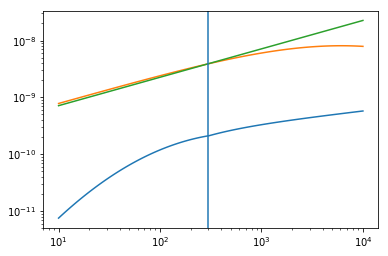

In [263]:
T=np.logspace(1,4,100)
plt.loglog(T,syn.k10h(T/1.e2))
plt.loglog(T,syn.k10e(T/1.e2))
plt.loglog(T,2.26e-9*np.sqrt(T/1.e2))
plt.axvline(300.)